<a href="https://colab.research.google.com/github/Zebrushka/AgroHackDS/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт модулей

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

import json
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import log_loss

     |████████████████████████████████| 76.4 MB 1.2 MB/s 


# Загрузка данных

Тренировочные данные состоят из полей 'text_id', 'text' и 11 полей с таргетами. Не стоит забывать, что может быть больше одной болезни для каждого случая.

Тестовые же данные содержат поля 'text_id' и 'text'.

In [25]:
train = pd.read_csv('/content/drive/MyDrive/Agrocode Hack/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Agrocode Hack/test.csv')

In [20]:
train.head()

,text_id,text,эймериоз,абсцесс,диспепсия молодняка,остертагиоз,мастит,инфекционный ринотрахеит,отёк вымени,тенденит,сибирская язва,лишай,другое
0,0,"Корова, видимо вставая, раздавила себе сосок. ...",0,0,0,0,1,0,0,0,0,0,0
1,1,Корове 8 лет! Месяц назад промеж четвертей вым...,0,0,0,0,0,0,0,0,1,1,1
2,2,"Молоко течёт само у коровы. Что делать, если у...",0,0,0,0,1,0,1,0,0,0,0
3,3,У нетели болячки на вымени.\nЗдравствуйте. Нет...,0,0,0,0,0,0,0,0,1,1,1
4,4,"У меня первотелка, на днях отёл, у неё левый п...",0,0,0,0,1,0,0,0,0,0,0


# TFiDF + SkLearn

In [29]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


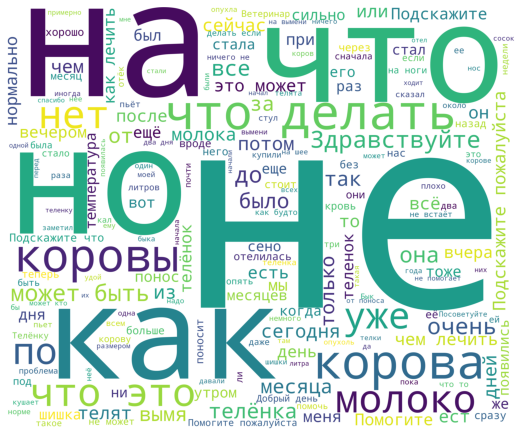

In [30]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud


corpus = get_corpus(train['text'].values)
procWordCloud = get_wordCloud(corpus)


fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# создаем мешок слов

# инициализируем
count_vect = CountVectorizer()
# составляем корпус документов
corpus = train['text']

# bow, от англ. bag of words
bow = count_vect.fit_transform(corpus)

print(bow.toarray())

# чтобы узнать количественное вхождение каждого слова:
matrix_freq = np.asarray(X.sum(axis=0)).ravel()
final_matrix = np.array([np.array(count_vect.get_feature_names()), matrix_freq])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [35]:
count_vect.get_feature_names()

['00',
 '08',
 '10',
 '100',
 '100мл',
 '10февраля',
 '11',
 '12',
 '1250',
 '13',
 '130',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '190',
 '1г4м',
 '1мл',
 '20',
 '200',
 '2018',
 '2019',
 '21',
 '23',
 '24',
 '27',
 '28',
 '2дня',
 '2л',
 '2мл',
 '2раза',
 '2х',
 '30',
 '300',
 '31',
 '32',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '3х',
 '40',
 '400',
 '400мг',
 '40мл',
 '45',
 '48',
 '50',
 '500',
 '5000',
 '50мл',
 '530',
 '70',
 '750',
 '7кг',
 '7л',
 '7мл',
 '80',
 '8л',
 '8мес',
 'mail',
 'nad',
 'ru',
 'snegirewa060457',
 'аборта',
 'абсцез',
 'абсцес',
 'августа',
 'авитаминоз',
 'авито',
 'аж',
 'азитронит',
 'ак',
 'аккуратно',
 'активированный',
 'активная',
 'активно',
 'активный',
 'активным',
 'алая',
 'аллергии',
 'аллергия',
 'ампулы',
 'анализ',
 'анализах',
 'анализы',
 'анального',
 'ангар',
 'антибиотик',
 'антибиотика',
 'антибиотиками',
 'антибиотики',
 'антибиотиков',
 'антибиотиком',
 'апитит',
 'аппаратом',
 'аппетит',
 'аппетита',
 'аппетитом',
 'аппитит'

In [37]:
# для работы со стоп-словами используем готовые списки из библиотеки nltk
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("russian")


# Удаление знаков пунктуации из текста
def remove_punct(text):
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [39]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("russian")

# Удаление знаков пунктуации из текста
def remove_punct(text):
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

train['text_clean'] = train['text'].map(lambda x: x.lower())
train['text_clean'] = train['text_clean'].map(lambda x: remove_punct(x))
train['text_clean'] = train['text_clean'].map(lambda x: x.split(' '))
train['text_clean'] = train['text_clean'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
train['text_clean'] = train['text_clean'].map(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
train[train.columns[2:13]].head()

,эймериоз,абсцесс,диспепсия молодняка,остертагиоз,мастит,инфекционный ринотрахеит,отёк вымени,тенденит,сибирская язва,лишай,другое
0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,1
2,0,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,1,1
4,0,0,0,0,1,0,0,0,0,0,0


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(train['text_clean']), train[train.columns[2:13]], test_size=0.2)

In [51]:
model = OneVsRestClassifier(estimator=CatBoostClassifier(iterations = 200, text_features=['text_clean'], 
                                                         verbose = 50, allow_writing_files=False))
model.fit(X_train, y_train)

Learning rate set to 0.024285
0:	learn: 0.6801199	total: 36.1ms	remaining: 7.18s
50:	learn: 0.3146125	total: 1.85s	remaining: 5.41s
100:	learn: 0.2247317	total: 3.67s	remaining: 3.6s
150:	learn: 0.1819734	total: 5.45s	remaining: 1.77s
199:	learn: 0.1520207	total: 7.21s	remaining: 0us
Learning rate set to 0.024285
0:	learn: 0.6773994	total: 33.3ms	remaining: 6.63s
50:	learn: 0.3600280	total: 1.79s	remaining: 5.23s
100:	learn: 0.2762113	total: 3.56s	remaining: 3.49s
150:	learn: 0.2315130	total: 5.37s	remaining: 1.74s
199:	learn: 0.1991901	total: 7.09s	remaining: 0us
Learning rate set to 0.024285
0:	learn: 0.6783770	total: 35ms	remaining: 6.97s
50:	learn: 0.3092426	total: 1.8s	remaining: 5.27s
100:	learn: 0.2234612	total: 3.61s	remaining: 3.54s
150:	learn: 0.1859984	total: 5.38s	remaining: 1.74s
199:	learn: 0.1531711	total: 7.11s	remaining: 0us
Learning rate set to 0.024285
0:	learn: 0.6759894	total: 35.1ms	remaining: 7s
50:	learn: 0.3156981	total: 1.82s	remaining: 5.33s
100:	learn: 0.231

OneVsRestClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x7fee0c3b7a10>,
                    n_jobs=None)

In [ ]:
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает 
# написание кода и улучшает его читаемость
from sklearn.pipeline import Pipeline

# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность 
# использования каждого слова из некоторого набора слов (количество слов набора 
# определяет размерность вектора) в каждом тексте
from sklearn.feature_extraction.text import TfidfVectorizer

# линейный классификатор и классификатор методом ближайших соседей
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# набор метрик для оценки качества модели
from sklearn import metrics

# модуль поиска по сетке параметров
from sklearn.model_selection import GridSearchCV

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])

knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

sgd_ppl_clf.fit(X_train, y_train)

knb_ppl_clf.fit(X_train, y_train)

In [ ]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

In [ ]:
predicted_sgd = knb_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

# RuBert

In [6]:
! pip install transformers
import torch
import transformers as ppb # pytorch transformers

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 43.2 MB/s 
     |████████████████████████████████| 596 kB 44.8 MB/s 
     |████████████████████████████████| 895 kB 70.2 MB/s 
     |████████████████████████████████| 56 kB 3.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
# создаем токенайзер для модели BERT, для его инициализации достаточно указать словарь, на котором обучалась предобученная модель
# BERT использует собственную токенизацию, никакой предобработки 

tokenizer = ppb.BertTokenizer(vocab_file='/content/drive/MyDrive/Agrocode Hack/vocab.txt')

In [9]:
# токенизируем текст каждого твита, для BERT не требуется никакая дополнительная предобработка, лемматизация и прочее

tokenized = train['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)) )

In [11]:
# Пример токенизации текста: на входе - текст, а на выходе имеем массив с номерами токенов из словаря модели BERT

print(train['text'][0])
print(tokenized[0])
print(tokenizer.tokenize(train['text'][0]))

Корова, видимо вставая, раздавила себе сосок. Разворотила всё в хлам, вместе с сосковым каналом. Доктор отказался что-либо делать, промыл и уехал. Если бы корова была в запуске сосок бы зарос да может и ладно бы (и трёхсисии нормально живут), но всё осложняется тем, что ей сегодня-завтра телиться и теперь из середины соска постоянно бежит молоко. Чё делать не знаю, хоть садись около неё и плачь. Может кто подскажет выход.
[101, 98113, 128, 29898, 25255, 1637, 128, 52983, 3297, 10379, 9097, 1770, 132, 63307, 3297, 4752, 845, 102083, 1565, 128, 6653, 869, 104417, 11170, 44269, 132, 13427, 14408, 1997, 130, 8568, 18716, 128, 7710, 13381, 851, 22793, 132, 7974, 1655, 98113, 3370, 845, 50809, 9097, 1770, 1655, 34780, 6974, 5269, 851, 31140, 1438, 1655, 120, 851, 11173, 30092, 1524, 43880, 22330, 122, 128, 3435, 4752, 84597, 4620, 128, 1997, 841, 852, 12904, 130, 41563, 4442, 6070, 851, 13231, 1703, 17691, 104417, 626, 14825, 51796, 44103, 132, 887, 842, 18716, 1699, 32889, 128, 28809, 13430

In [12]:
# инициализируем предобученную модель RuBERT из файла, 
# в json-файле конфигурации описаны параметры модели

config = ppb.BertConfig.from_json_file('/content/drive/MyDrive/Agrocode Hack/config.json')
model = ppb.BertModel.from_pretrained('/content/drive/MyDrive/Agrocode Hack/pytorch_model.bin', config = config)

In [13]:
# из-за того, что каждый твит в датасете имеет разную длину (количество токенов)
# мы делаем паддинг - заполнение нулями каждого массива токенов до длины максимального массива
# чтобы на выходе получить матрицу из токенизированных текстов одной длины

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [22]:
# посмотрим на размерность матрицы токенизированных твитов после паддинга

np.array(padded).shape

(294, 809)

In [15]:
# Накладываем маску на значимые токены
# В данном случае нам важны все слова кроме нулевых токенов, появившихся на предыдущем шаге паддинга

attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(294, 809)

In [24]:
# а теперь сформируем вектора текстов с помощью модели RuBERT

# это не быстрый процесс, импортируем инструмент для визуализации времени обработки в цикле
from tqdm import notebook

# для того, чтобы модель отработала в условиях ограниченных ресурсов - оперативной памяти, мы разделяем входной датасет на батчи.
# при батче в 100 твитов потребление оперативной памяти укладывается в 1Гб
batch_size = 1

# Делаем пустой список для хранения эмбеддингов (векторов) твитов
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        # преобразуем батч с токенизированными твитами в тензор 
        # по сути тензор - это многомерный массив, который может быть обработан нейронной сетью
        input_ids = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        
        # создаем тензор и для подготовленной маски
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        # передаем в модель BERT тензор из твитов и маску - на выходе получаем эмбеддинги - вектор текста твита
        # torch.no_grad() - для ускорения инференса модели отключим рассчет градиентов
        with torch.no_grad():
            last_hidden_states = model(input_ids, attention_mask=attention_mask_batch)
        
        # в итоге собираем все эмбеддинги твитов в features
        embeddings.append(last_hidden_states[0][:,0,:].numpy())

  0%|          | 0/294 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
# преобразуем список батчей эмбеддингов в numpy-матрицу 
features = np.concatenate(embeddings)

In [ ]:
# выводим размерность полученной матрицы эмбеддингов
# данная модель BERT формирует вектора текстов в 768-мерном пространстве признаков
features.shape

In [ ]:
# Выводим пример эмбеддинга для твита - осторожно много цифр!

print(df_tweets['text'][0])
print(features[0])

In [ ]:
# Импортируем необходимые библиотеки для обучения классификатора на logreg и оценки качества

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
# Сохраним целевую переменную: метку тональности позитив/негатив

labels = df_tweets['positive']

In [ ]:
# Разделяем матрицу признаков и целевую переменную на обучающий и тестовый набор

train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
# обучаем классификатор на основе логистической регрессии

lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

In [ ]:
# делаем пробное предсказание
tweet_index = 555

print('Text: ' + df_tweets['text'][tweet_index])
print('Predict label: ', lr_clf.predict(features[tweet_index:tweet_index+1][:])[0])
print('True label: ', df_tweets['positive'][tweet_index])

In [ ]:
# оцениваем accuracy на тестовой выборке

lr_clf.score(test_features, test_labels)

# Базовая модель

В качестве базового решения используется CatBoostClassifier, поддерживающий текстовые фичи. Помимо этого задача является мультилейбл классификацией, поэтому модель обернута в OneVsRestClassifier.

**Делим данные на тренировочную и валидационную выборку**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(train['text']), train[train.columns[2:]], test_size=0.2)

**Обучаем модель**

In [ ]:
model = OneVsRestClassifier(estimator=CatBoostClassifier(iterations = 100, text_features=['text'], 
                                                         verbose = 50, allow_writing_files=False))
model.fit(X_train, y_train)

Learning rate set to 0.045854
0:	learn: 0.6750223	total: 90.4ms	remaining: 8.95s
50:	learn: 0.3992793	total: 1.85s	remaining: 1.78s
99:	learn: 0.3346489	total: 3.54s	remaining: 0us
Learning rate set to 0.045854
0:	learn: 0.6736297	total: 35.3ms	remaining: 3.5s
50:	learn: 0.3749512	total: 1.75s	remaining: 1.68s
99:	learn: 0.3172577	total: 3.4s	remaining: 0us
Learning rate set to 0.045854
0:	learn: 0.6745299	total: 34ms	remaining: 3.37s
50:	learn: 0.3882340	total: 1.78s	remaining: 1.71s
99:	learn: 0.3269351	total: 3.48s	remaining: 0us
Learning rate set to 0.045854
0:	learn: 0.6714341	total: 38.2ms	remaining: 3.78s
50:	learn: 0.3663993	total: 1.74s	remaining: 1.68s
99:	learn: 0.3109305	total: 3.42s	remaining: 0us
Learning rate set to 0.045854
0:	learn: 0.6741982	total: 35.9ms	remaining: 3.56s
50:	learn: 0.3477512	total: 1.76s	remaining: 1.7s
99:	learn: 0.2814248	total: 3.43s	remaining: 0us
Learning rate set to 0.045854
0:	learn: 0.6723350	total: 33.7ms	remaining: 3.33s
50:	learn: 0.347180

OneVsRestClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x7f6c6a26ae10>,
                    n_jobs=None)

# Считаем метрику

В качестве "gt" (ground truth) функция принимает на вход датафрейм/массив из 10 столбцов (все классы, кроме "другое"). Предсказанные значения – "pr", также должны быть либо в виде датафрейма, либо в виде массива.

In [46]:
def log_loss_score(gt, pr):
    
    log_loss_ = 0
    
    gt = np.array(gt)
    
    for i in range(10):
        log_loss_ += log_loss(gt[:, i], pr[:, i])
        
    return log_loss_ / 10

In [52]:
log_loss_score(y_val, model.predict_proba(X_val))

0.3115961620118631

# Создание файла отправки

В файле с ответами должны быть вероятности для каждого класса. Сумма вероятностей в каждой строке может быть больше 1.

In [50]:
submission_columns = ['text_id'] + list(train.columns[2:-1])
submission = pd.concat([test['text_id'], pd.DataFrame(model.predict_proba(pd.DataFrame(test['text']))[:, :12])], axis=1)
submission.columns = submission_columns

CatBoostError: ignored

In [ ]:
submission.head()

,text_id,эймериоз,абсцесс,диспепсия молодняка,остертагиоз,мастит,инфекционный ринотрахеит,отёк вымени,тенденит,сибирская язва,лишай
0,294,0.062719,0.113136,0.072705,0.074253,0.103621,0.075186,0.066241,0.057393,0.104223,0.061639
1,295,0.567817,0.143268,0.392205,0.375057,0.211739,0.133588,0.136544,0.406265,0.173632,0.088913
2,296,0.198515,0.120845,0.369088,0.180145,0.233022,0.078119,0.065792,0.311344,0.104504,0.063568
3,297,0.065979,0.148187,0.077228,0.087859,0.083386,0.069549,0.060314,0.062278,0.103982,0.068143
4,298,0.068813,0.138642,0.084449,0.083486,0.188230,0.067497,0.089238,0.067269,0.115569,0.089609


In [ ]:
submission_json = {str(k): {"span": list(), "label": list(v.values())} \
                   for k,v in submission.set_index('text_id').to_dict('index').items()}

submission_json['294']

{'span': [],
 'label': [0.0627194363685613,
  0.11313570529902758,
  0.07270482269352871,
  0.0742534689467756,
  0.10362104310746847,
  0.07518588621133018,
  0.06624119018743685,
  0.05739265274755671,
  0.10422273080497868,
  0.061638782036372346]}

In [ ]:
with open('sample_submission.json', 'w') as final_submit:
    json.dump(submission_json, final_submit, indent=4)